In [1]:
!pip install kaggle
!pip install scikit-learn --upgrade
import glob
import zipfile
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
 
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
 
!kaggle datasets download -d iabhishekofficial/mobile-price-classification
 
 
 
file = glob.glob('*.zip')[0]
with zipfile.ZipFile(file, 'r') as zip_ref:
  zip_ref.extractall('files')

     |████████████████████████████████| 22.3 MB 36 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Saving kaggle.json to kaggle.json
  0% 0.00/70.6k [00:00<?, ?B/s]
100% 70.6k/70.6k [00:00<00:00, 26.6MB/s]


In [2]:
import scipy
import warnings
import itertools
import numpy as np
import scipy.stats
import scipy.linalg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import *
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import *
sns.set()
warnings.filterwarnings('ignore')

In [3]:
def onehot_encode(df, column):    
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column, dtype=bool)
    df = pd.concat([dummies, df], axis=1)
    df = df.drop([column], axis=1)   
    return df 
  
def network(df):
  df['network'] = None
  df.loc[(df['three_g']==0) & (df['four_g']==0),'network'] = 0
  df.loc[(df['three_g']==1) & (df['four_g']==0),'network'] = 1
  df.loc[(df['three_g']==1) & (df['four_g']==1),'network'] = 2
  df.drop(['three_g','four_g'],axis=1, inplace=True)

def preprocess(df):
  if 'id' in list(df):
    df.drop('id', inplace=True,axis=1)
  df = df[df.px_height>0]
  df = df[df.px_width>0]
  # df = df[df.sc_h>0]
  # df = df[df.sc_w>0]
  # df.drop(['m_dep','mobile_wt'], inplace=True,axis=1)
  
  network(df)
  # df['total_cpu'] = df['clock_speed'] * df['n_cores']
  # df['total_cpu'] = pd.cut(df['total_cpu'], 3, labels=False)
  df['lcd'] = (np.sqrt(df['sc_h']**2+df['sc_w']**2)*.3937).round(2)
  df['ppi'] = (np.sqrt(df['px_height']**2+df['px_width']**2) / df['lcd']).round()
  df['aspect_ratio'] = (df['px_width']/df['px_height']).round(2)
  
  # df['n_cam'] = None
  # df.loc[(df['fc']==0) & (df['pc']==0),'n_cam'] = 0
  # df.loc[(df['fc']>0) & (df['pc']==0),'n_cam'] = 1
  # df.loc[(df['fc']==0) & (df['pc']>0),'n_cam'] = 1
  # df.loc[(df['fc']>0) & (df['pc']>0),'n_cam'] = 2
  
  # df['cpu'] = pd.cut(df['clock_speed'], 5, labels=False)
  # df.drop('clock_speed',axis=1, inplace=True)
  
  df['battery'] = pd.cut(df['battery_power'], 5, labels=False)
  # df.drop('battery_power',axis=1, inplace=True)
  

  # df['mem'] = pd.cut(df['ram'], 10, labels=False)
  # df.drop('ram',axis=1, inplace=True)

  # for col in ['blue','dual_sim','touch_screen','wifi']:
  #   df = onehot_encode(df, col)
  
  # df['battery_power'] = df['battery_power'].round(-1)
  # df['int_memory'] = df['int_memory'].round(-1)
  
  cols = list(df)
  if 'price_range' in cols:
    cols.remove('price_range')
    df = df[cols + ['price_range']]
  return df

In [4]:
train = pd.read_csv('files/train.csv')
test = pd.read_csv('files/test.csv')

train = preprocess(train)
test = preprocess(test)

y = train.iloc[:,-1].to_numpy()
X = train.iloc[:,:-1].to_numpy()



In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-1, 1e-3, 'scale'], 'svc__C': [ 1, 100, 1000]},
              {'svc__kernel': ['linear'], 'svc__C': [1, 100, 1000]},
              {'svc__kernel': ['poly'], 'svc__degree':[2, 3], 'svc__C': [1, 100, 1000]}
              ]

pipe = Pipeline(steps=[('scale', StandardScaler()), ('svc', SVC(class_weight='balanced'))])

clf = GridSearchCV(pipe, parameters,return_train_score=True,verbose=2)
clf.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.3s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.3s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.3s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.3s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.3s
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.2s
[CV] END ........svc__C=1, svc__gamma=scale, svc

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid=[{'svc__C': [1, 100, 1000],
                          'svc__gamma': [0.1, 0.001, 'scale'],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [1, 100, 1000], 'svc__kernel': ['linear']},
                         {'svc__C': [1, 100, 1000], 'svc__degree': [2, 3],
                          'svc__kernel': ['poly']}],
             return_train_score=True, verbose=2)

In [ ]:
df = pd.DataFrame(clf.cv_results_)
df.drop(['mean_fit_time','std_fit_time','mean_score_time','std_score_time','split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'std_train_score','params'],axis=1, inplace=True)
df.columns = ['C', 'Gamma (RBF)', 'Kernel', 'Degree(Poly)', 'Test Accuracy', 'Train Accuracy']
df = df[['Kernel', 'C', 'Gamma (RBF)', 'Degree(Poly)', 'Test Accuracy', 'Train Accuracy']]
df.fillna('-',inplace=True)
df['Test Accuracy'] = 100 * df['Test Accuracy'].round(4)
df['Train Accuracy'] = 100 * df['Train Accuracy'].round(4)
print(df.to_csv('svm-result.csv',index=False))

None


In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import tree
parameters = {'dc__criterion': ['gini','entropy'], 'dc__splitter':['random', 'best'], 'dc__max_depth':[5,10,15,20]}

pipe = Pipeline(steps=[('dc', tree.DecisionTreeClassifier())])

clf = GridSearchCV(pipe, parameters,return_train_score=True,verbose=2)
clf.fit(X, y)

clf.cv_results_['mean_test_score']

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=random; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=random; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=random; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=random; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=random; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=best; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=best; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=best; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=best; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__splitter=best; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=10, dc__splitter=random; total time=   0.0s
[C

array([0.77229449, 0.82331955, 0.83382581, 0.82883584, 0.81031328,
       0.82883208, 0.82081955, 0.82282832, 0.76827193, 0.81980451,
       0.82130827, 0.84483709, 0.83032456, 0.84132832, 0.83784962,
       0.84833709])

In [6]:
df = pd.DataFrame(clf.cv_results_)
df.drop(['mean_fit_time','std_fit_time','mean_score_time','std_score_time','split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'std_train_score','params'],axis=1, inplace=True)
df.columns = ['Criterion', 'Max depth' ,'Splitter', 'Test Accuracy', 'Train Accuracy']
# df = df[['Kernel', 'C', 'Gamma (RBF)', 'Degree(Poly)', 'Test Accuracy', 'Train Accuracy']]
# df.fillna('-',inplace=True)
df['Test Accuracy'] = 100 * df['Test Accuracy'].round(4)
df['Train Accuracy'] = 100 * df['Train Accuracy'].round(4)
# df
print(df.to_csv('dc-result.csv',index=False))

None


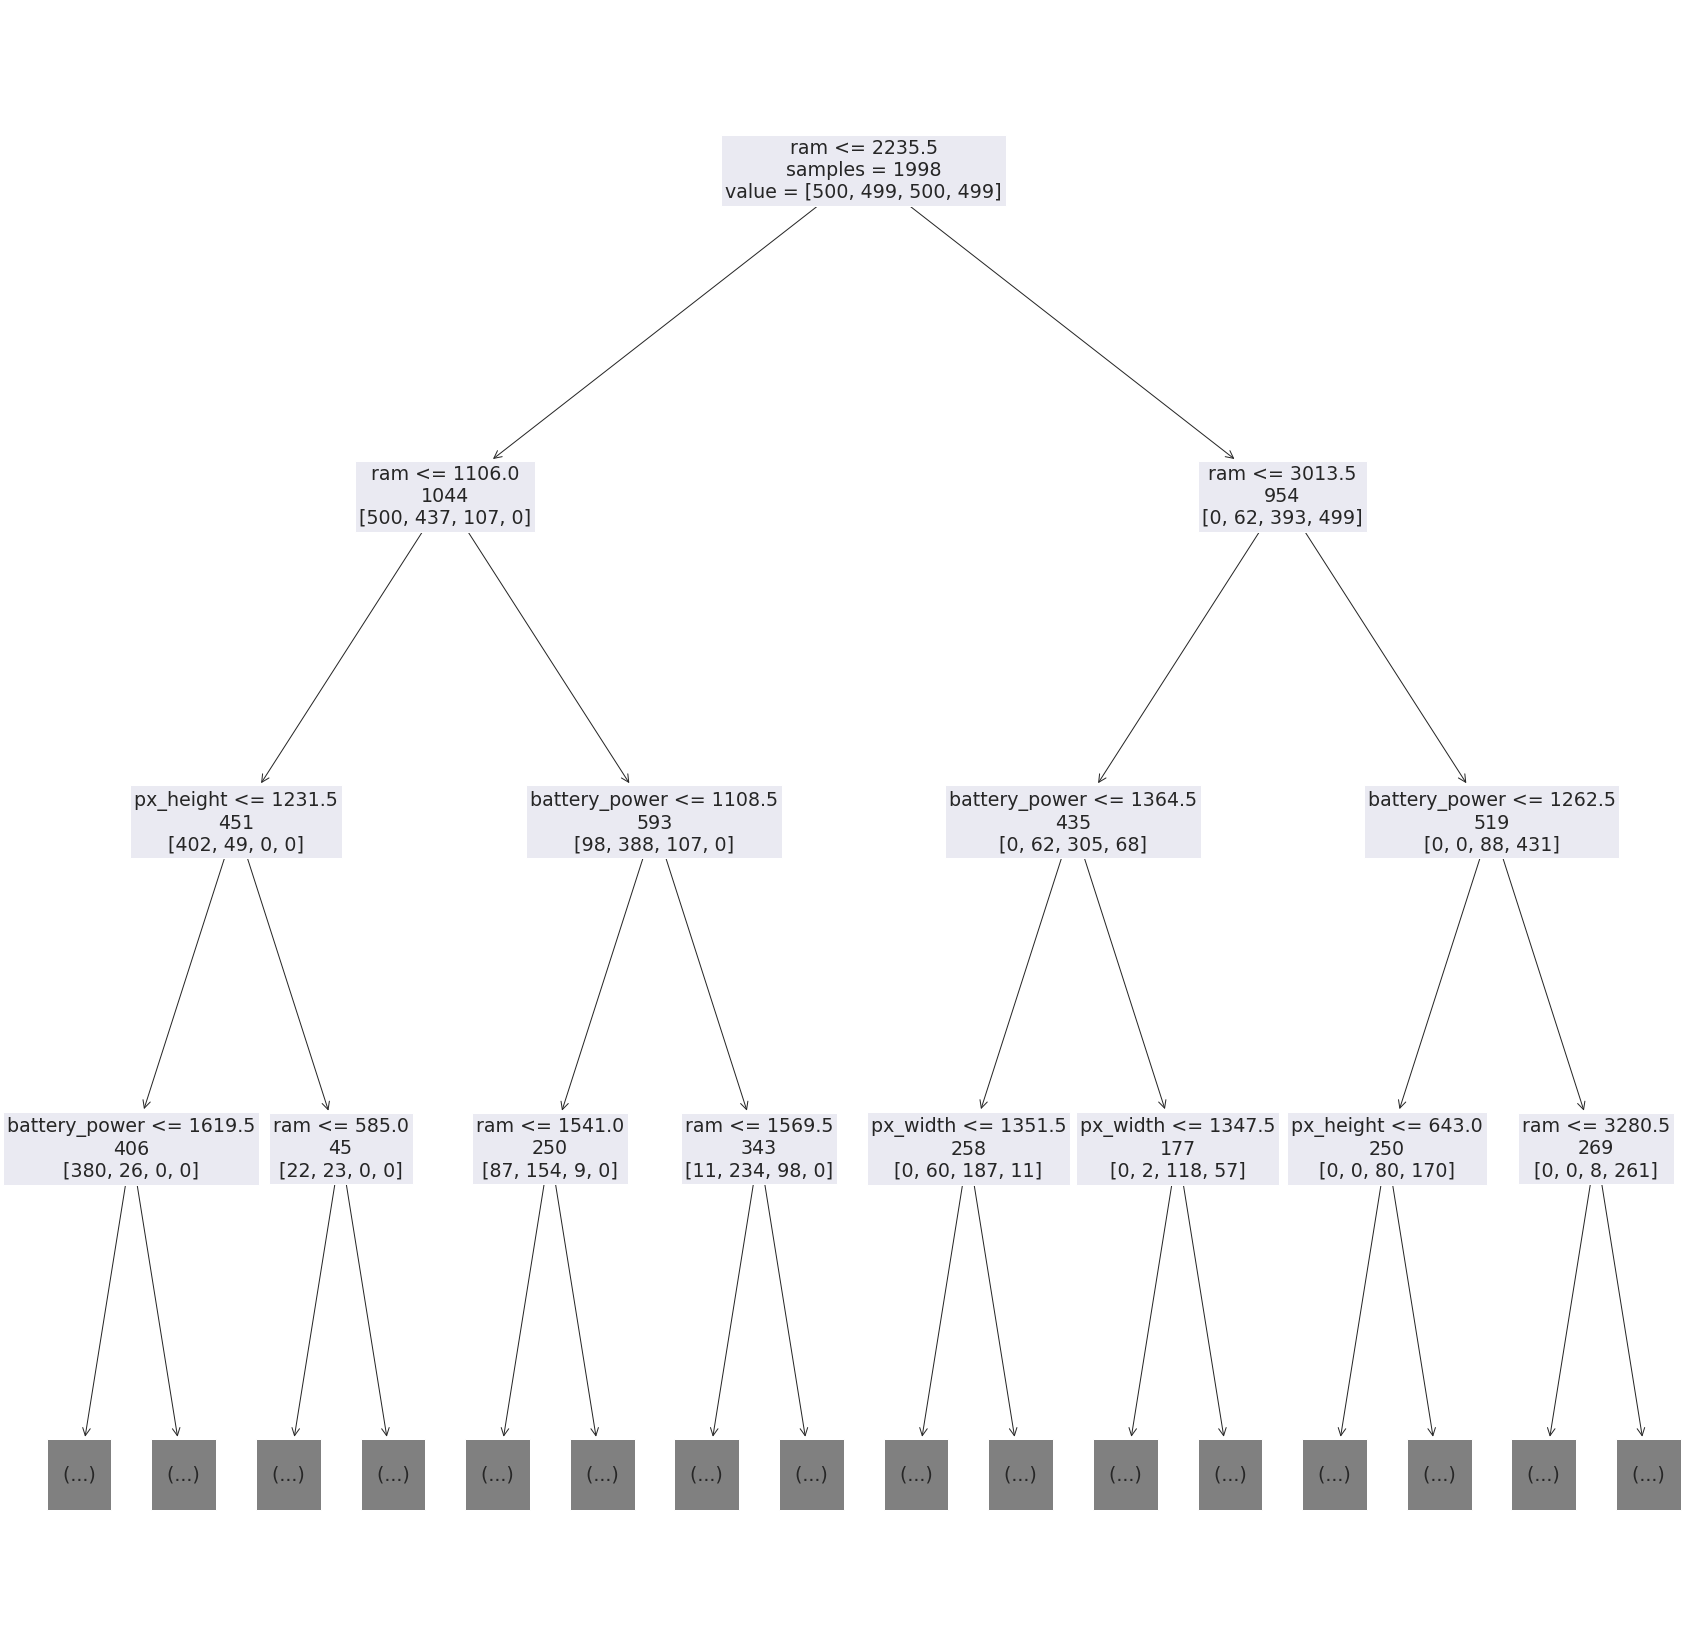

In [7]:
fig,ax = plt.subplots(1,1,figsize=(30,30))
c=clf.best_estimator_['dc']
tree.plot_tree(c,ax=ax, max_depth=3,feature_names=list(train.columns),fontsize=19, impurity=False, label='root')
None

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

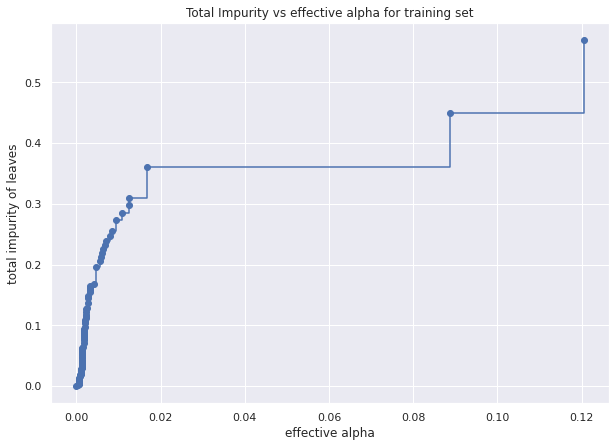

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [14]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.18032753430081727


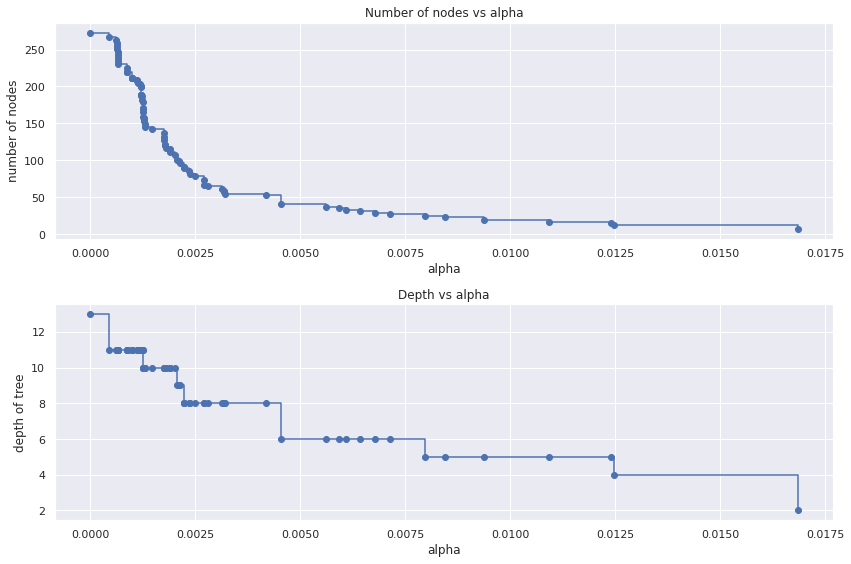

In [17]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(12,8))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

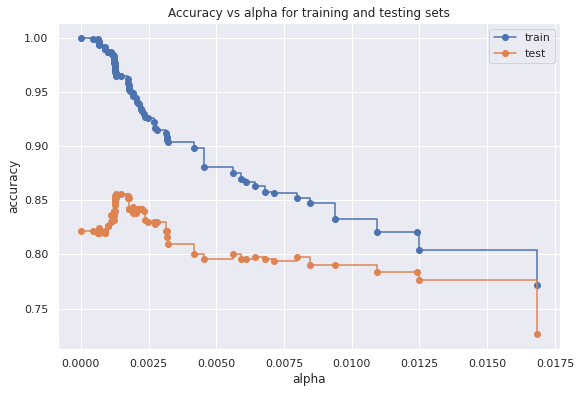

In [20]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(9,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier


parameters = {'dc__criterion': ['gini','entropy'], 'dc__n_estimators':[10,100], 'dc__max_depth':[5,10,15,20]}

pipe = Pipeline(steps=[('scale', StandardScaler()), ('dc', RandomForestClassifier())])

clf = GridSearchCV(pipe, parameters,return_train_score=True,verbose=2)
clf.fit(X, y)

clf.cv_results_['mean_test_score']

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=10; total time=   0.1s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=10; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=10; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=10; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=10; total time=   0.0s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=100; total time=   0.3s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=100; total time=   0.3s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=100; total time=   0.3s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=100; total time=   0.3s
[CV] END dc__criterion=gini, dc__max_depth=5, dc__n_estimators=100; total time=   0.3s
[CV] END dc__criterion=gini, dc__max_depth=10, dc__n_estimators=10; total 

array([0.74774937, 0.84484586, 0.79278822, 0.87486591, 0.78326441,
       0.87736967, 0.78527068, 0.87987594, 0.72322055, 0.83483208,
       0.79678571, 0.87687469, 0.81480201, 0.88137093, 0.81932206,
       0.88737594])

In [ ]:
df = pd.DataFrame(clf.cv_results_)
df

df.drop(['mean_fit_time','std_fit_time','mean_score_time','std_score_time','split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'std_train_score','params'],axis=1, inplace=True)
df.columns = ['Criterion', 'Max depth' ,'# of estimations', 'Test Accuracy', 'Train Accuracy']
# df = df[['Kernel', 'C', 'Gamma (RBF)', 'Degree(Poly)', 'Test Accuracy', 'Train Accuracy']]
# df.fillna('-',inplace=True)
df['Test Accuracy'] = 100 * df['Test Accuracy'].round(4)
df['Train Accuracy'] = 100 * df['Train Accuracy'].round(4)
# df
print(df.to_csv('rf-result.csv',index=False))

None
